<a href="https://colab.research.google.com/github/Riyabelle25/Stock-Market-Prediction-using-Numerical-and-Textual-Analysis/blob/main/TSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Market Prediction using Numerical and Textual Analysis**
 *-Riya Elizabeth John, undergrad sophomore at IIT Roorkee*

## First up, let's import the necessary modules, the BSESN and News-Headlines data:

In [1]:
!pip install 'scikit-learn==0.24.0' # Have to use this version of scikit-learn, for mean_absolute_error 

import pandas as pd
import numpy as np
from numpy import concatenate
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [5]:
df_prices = pd.read_csv('/content/BSESN.csv')
df_prices

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-14,41883.089844,41994.261719,41770.898438,41952.628906,41952.628906,14100.0
1,2020-01-15,41969.859375,41969.859375,41648.109375,41872.730469,41872.730469,6100.0
2,2020-01-16,41924.738281,42059.449219,41812.281250,41932.558594,41932.558594,6600.0
3,2020-01-17,41929.019531,42063.929688,41850.289063,41945.371094,41945.371094,9500.0
4,2020-01-20,42263.000000,42273.871094,41503.371094,41528.910156,41528.910156,7500.0
...,...,...,...,...,...,...,...
247,2021-01-08,48464.910156,48854.339844,48365.578125,48782.511719,48782.511719,22200.0
248,2021-01-11,49252.308594,49303.789063,48956.378906,49269.320313,49269.320313,21200.0
249,2021-01-12,49228.261719,49569.140625,49079.570313,49517.109375,49517.109375,12700.0
250,2021-01-13,49763.929688,49795.191406,49073.851563,49492.320313,49492.320313,27200.0


In [4]:
cols = ['Date','Category','News']
df_news = pd.read_csv('/content/india-headlines.csv', names = cols)
df_news = df_news.dropna(axis = 0, how ='any') 
df_news

,Date,Category,News
0,20200101,life-style.events,Happy New Year 2020: Images; Quotes; Wishes; M...
1,20200101,city.bhubaneswar,Bone-clling cold wavecontinues to sweep state
2,20200101,city.hyderabad,T gained 163 sq km forest cover
3,20200101,city.hyderabad,Draft electoral rolls published
4,20200101,city.koc,Invasive species increasing in Kerala's core f...
...,...,...,...
90868,20200630,gadgets-news,why tiktok removed 1 65 crore videos in india
90869,20200630,entertainment.ndi.bollywood,apurva asrani calls alia bhatts mother soni ra...
90870,20200630,entertainment.ndi.bollywood,kangana ranaut gets a doll version of herself ...
90871,20200630,entertainment.ndi.bollywood,meezaan jaffrey reminisces s cldhood days with...


## Cleaning and Pre-processing the data:

In [6]:
# Dropping 0 values, and the Category column as we don't require this for our analysis.
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)

In [7]:
# Converting 'Date' columns from both our dataframes to type datetime
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-14,41883.089844,41994.261719,41770.898438,41952.628906,41952.628906,14100.0
1,2020-01-15,41969.859375,41969.859375,41648.109375,41872.730469,41872.730469,6100.0
2,2020-01-16,41924.738281,42059.449219,41812.281250,41932.558594,41932.558594,6600.0
3,2020-01-17,41929.019531,42063.929688,41850.289063,41945.371094,41945.371094,9500.0
4,2020-01-20,42263.000000,42273.871094,41503.371094,41528.910156,41528.910156,7500.0
...,...,...,...,...,...,...,...
247,2021-01-08,48464.910156,48854.339844,48365.578125,48782.511719,48782.511719,22200.0
248,2021-01-11,49252.308594,49303.789063,48956.378906,49269.320313,49269.320313,21200.0
249,2021-01-12,49228.261719,49569.140625,49079.570313,49517.109375,49517.109375,12700.0
250,2021-01-13,49763.929688,49795.191406,49073.851563,49492.320313,49492.320313,27200.0


In [8]:
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2020-01-01,Bone-clling cold wavecontinues to sweep state ...
1,2020-01-02,Horoscope Today; 02 January 2020: Read predict...
2,2020-01-03,Bank Holidays in 2020 Mazya Navryac Bayko upda...
3,2020-01-04,Mamta Mohandas plays a nurse in Lalbagh Tolly ...
4,2020-01-05,Homing in on 2020 Beauty in blue Live it up in...
...,...,...
177,2020-06-26,Containment zone residents slam gh prices char...
178,2020-06-27,like me i wont let you have a toxic relationsp...
179,2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...
180,2020-06-29,6 hot and stylish bikini looks of Katrina Kaif...


In [9]:
# Cleaning headlines
c = []

for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    print(i)
    news=' '.join(news)
    c.append(news)    
    # news = [word for word in news if word not in set(stopwords.words('english'))]
    # print(news)
    # news = []
    # for w in news: news.append(ps.stem(w))
    # print(news)
    # news=' '.join(news)
    # print(news)
    # c.append(news)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181


In [10]:
df_news['News'] = pd.Series(c)
df_news

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,News
0,2020-01-01,bone clling cold wavecontinu sweep state gain ...
1,2020-01-02,horoscop today januari read predict ari tauru ...
2,2020-01-03,bank holiday mazya navryac bayko updat januari...
3,2020-01-04,mamta mohanda play nurs lalbagh tolli celeb op...
4,2020-01-05,home beauti blue live diet induc sound sleep y...
...,...,...
177,2020-06-26,contain zone resid slam gh price charg veget v...
178,2020-06-27,like wont let toxic relationsp food major ravi...
179,2020-06-28,atanu ghosh plan rewrit old script make relev ...
180,2020-06-29,hot stylish bikini look katrina kaif anna eden...


## Calculating Subjectivity and Polarity scores using TextBlob module:

In [11]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [12]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,News,Subjectivity,Polarity
0,2020-01-01,bone clling cold wavecontinu sweep state gain ...,0.407322,0.040349
1,2020-01-02,horoscop today januari read predict ari tauru ...,0.410638,0.078692
2,2020-01-03,bank holiday mazya navryac bayko updat januari...,0.370711,0.085875
3,2020-01-04,mamta mohanda play nurs lalbagh tolli celeb op...,0.389496,0.126830
4,2020-01-05,home beauti blue live diet induc sound sleep y...,0.350895,0.093071
...,...,...,...,...
177,2020-06-26,contain zone resid slam gh price charg veget v...,0.324106,0.066983
178,2020-06-27,like wont let toxic relationsp food major ravi...,0.371791,0.063043
179,2020-06-28,atanu ghosh plan rewrit old script make relev ...,0.368076,0.054104
180,2020-06-29,hot stylish bikini look katrina kaif anna eden...,0.370906,0.061918


## Carrying out Sentimental Analysis on the News Headlines:

In [13]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2020-01-01,bone clling cold wavecontinu sweep state gain ...,0.407322,0.040349,-0.9998,0.151,0.777,0.071
1,2020-01-02,horoscop today januari read predict ari tauru ...,0.410638,0.078692,-0.9998,0.155,0.766,0.079
2,2020-01-03,bank holiday mazya navryac bayko updat januari...,0.370711,0.085875,-0.9994,0.122,0.790,0.088
3,2020-01-04,mamta mohanda play nurs lalbagh tolli celeb op...,0.389496,0.126830,-0.9998,0.146,0.780,0.074
4,2020-01-05,home beauti blue live diet induc sound sleep y...,0.350895,0.093071,-0.9999,0.156,0.772,0.072
...,...,...,...,...,...,...,...,...
177,2020-06-26,contain zone resid slam gh price charg veget v...,0.324106,0.066983,-0.9998,0.142,0.790,0.068
178,2020-06-27,like wont let toxic relationsp food major ravi...,0.371791,0.063043,-0.9998,0.139,0.791,0.070
179,2020-06-28,atanu ghosh plan rewrit old script make relev ...,0.368076,0.054104,-0.9998,0.135,0.801,0.064
180,2020-06-29,hot stylish bikini look katrina kaif anna eden...,0.370906,0.061918,-0.9998,0.130,0.800,0.069


## Now here's the fun part!
## We will use our **Sentimental Analysis findings** along with the historical prices data for predicting stock prices **using Multivariate Time Series Forecasting**:



In [14]:
# Merging our findings (the updated News dataframe) with the Prices dataframe
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
print(df_prices)
df_merge.drop('Date', axis = 1, inplace=True)
df_merge.drop('News', axis=1, inplace=True)
print(df_merge.columns)
print(len(df_merge))
print(len(df_prices))
print(len(df_news))

          Date          Open          High  ...         Close     Adj Close   Volume
0   2020-01-14  41883.089844  41994.261719  ...  41952.628906  41952.628906  14100.0
1   2020-01-15  41969.859375  41969.859375  ...  41872.730469  41872.730469   6100.0
2   2020-01-16  41924.738281  42059.449219  ...  41932.558594  41932.558594   6600.0
3   2020-01-17  41929.019531  42063.929688  ...  41945.371094  41945.371094   9500.0
4   2020-01-20  42263.000000  42273.871094  ...  41528.910156  41528.910156   7500.0
..         ...           ...           ...  ...           ...           ...      ...
247 2021-01-08  48464.910156  48854.339844  ...  48782.511719  48782.511719  22200.0
248 2021-01-11  49252.308594  49303.789063  ...  49269.320313  49269.320313  21200.0
249 2021-01-12  49228.261719  49569.140625  ...  49517.109375  49517.109375  12700.0
250 2021-01-13  49763.929688  49795.191406  ...  49492.320313  49492.320313  27200.0
251 2021-01-14  49432.828125  49663.578125  ...  49584.160156  49

In [15]:
# getting our data series ready for Multivariate Time Series Forecasting
from pandas import DataFrame as df
from pandas import concat
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df1 = df(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df1.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df1.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [16]:
# scale our data for optimal performance
values = df_merge.values
print(df_merge)
print(values)
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[12,13,14,16,17,18,19,20,21,22,23]], axis=1, inplace=True)
print(reframed.columns)

             Open          High           Low  ...  Negative  Neutral  Positive
0    41883.089844  41994.261719  41770.898438  ...     0.143    0.783     0.074
1    41969.859375  41969.859375  41648.109375  ...     0.140    0.784     0.076
2    41924.738281  42059.449219  41812.281250  ...     0.158    0.766     0.076
3    41929.019531  42063.929688  41850.289063  ...     0.172    0.760     0.067
4    42263.000000  42273.871094  41503.371094  ...     0.160    0.767     0.073
..            ...           ...           ...  ...       ...      ...       ...
108  35679.738281  35706.550781  34794.929688  ...     0.126    0.807     0.067
109  34525.390625  35081.609375  34499.781250  ...     0.152    0.796     0.052
110  35144.781250  35254.878906  34910.339844  ...     0.142    0.790     0.068
111  34926.949219  35032.359375  34662.058594  ...     0.130    0.800     0.069
112  35168.300781  35233.910156  34812.800781  ...     0.134    0.818     0.048

[113 rows x 12 columns]
[[4.18830898e+0

### Building a **LSTM** **(Long Short Term Memory)** Model to predict Stock Prices:

In [17]:
# split into train and test sets
values = reframed.values
print((values).shape)
n_train_hours = 90
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(112, 13)
(90, 1, 12) (90,) (22, 1, 12) (22,)


Epoch 1/50
2/2 - 2s - loss: 0.6231 - val_loss: 0.5447
Epoch 2/50
2/2 - 0s - loss: 0.5880 - val_loss: 0.5118
Epoch 3/50
2/2 - 0s - loss: 0.5535 - val_loss: 0.4789
Epoch 4/50
2/2 - 0s - loss: 0.5194 - val_loss: 0.4460
Epoch 5/50
2/2 - 0s - loss: 0.4852 - val_loss: 0.4130
Epoch 6/50
2/2 - 0s - loss: 0.4511 - val_loss: 0.3798
Epoch 7/50
2/2 - 0s - loss: 0.4171 - val_loss: 0.3463
Epoch 8/50
2/2 - 0s - loss: 0.3828 - val_loss: 0.3125
Epoch 9/50
2/2 - 0s - loss: 0.3492 - val_loss: 0.2784
Epoch 10/50
2/2 - 0s - loss: 0.3163 - val_loss: 0.2438
Epoch 11/50
2/2 - 0s - loss: 0.2837 - val_loss: 0.2088
Epoch 12/50
2/2 - 0s - loss: 0.2510 - val_loss: 0.1734
Epoch 13/50
2/2 - 0s - loss: 0.2205 - val_loss: 0.1379
Epoch 14/50
2/2 - 0s - loss: 0.1940 - val_loss: 0.1032
Epoch 15/50
2/2 - 0s - loss: 0.1757 - val_loss: 0.0716
Epoch 16/50
2/2 - 0s - loss: 0.1633 - val_loss: 0.0465
Epoch 17/50
2/2 - 0s - loss: 0.1552 - val_loss: 0.0299
Epoch 18/50
2/2 - 0s - loss: 0.1483 - val_loss: 0.0237
Epoch 19/50
2/2 - 0

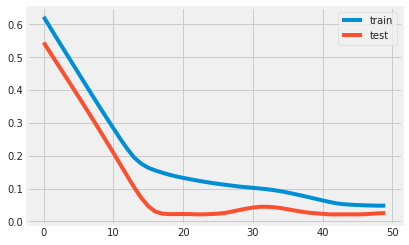

In [22]:
# design the network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam') 

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### **Testing** the LSTM Model with the test data and calculating **RMSE(Root Mean Square Error)**:

In [25]:
# make a prediction
print(test_X.shape)
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[2]))
print(test_X.shape)
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


(22, 1, 12)
(22, 1, 12)
Test RMSE: 475.102


# Hence we observe RMSE of **475.102**, i.e predicted prices can be off by 475.102 units, and the built Hybrid model works excellently. 
## This is a pretty good RMSE, considering the sensex prices are in the order of 4 (for eg, around 48k units). 